In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device, summarize_results

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from utils.results import bootstrap_ensemble, interactive_plot_predictions
import torch
import torch.nn as nn


TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [2]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [3]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [4]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, _ = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="pct", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.001, 0.005, 0.01], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

print(all_gts['country'].unique())

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


## Simple Prediction Model

Using cuda device


  0%|          | 0/100 [00:00<?, ?it/s]

Final training loss: 0.2268841713666916
Final validation loss: 0.559646487236023
Final validation R^2: 0.2104080597045188


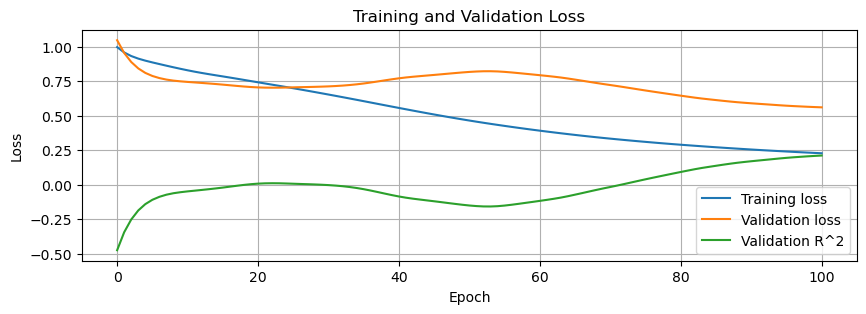

In [5]:
model, training_loss, validation_loss, validation_r_squared = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=5e-4, 
                                                                       weight_decay=1e-1, 
                                                                       verbose=True,
                                                                       seed=SEED)

## Ensembling

In [6]:
train_fn = lambda seed: train_nn(X_train, y_train, X_valid, y_valid, num_epochs=100, learning_rate=5e-4, weight_decay=1e-1, verbose=False, seed=seed)
results = bootstrap_ensemble(X_valid, y_valid, train_fn, n_ensembling=100, seed=SEED, device=get_device(False))

best_model = results['best_model']
y_pred_best = results['y_pred_best']
y_pred_mean = results['y_pred_mean']
y_pred_std = results['y_pred_std']
y_pred_median = results['y_pred_median']
best_rsquared = results['best_rsquared']
mse_ensemble = results['mse_ensemble']
rsquared_ensemble = results['rsquared_ensemble']

Bootstrapping Ensembling:   0%|          | 0/100 [00:00<?, ?it/s]

Ensemble R2: 0.3074644354333098
Ensemble MSE: 0.490854951639318
Ensemble MAPE: 127.80182139012209


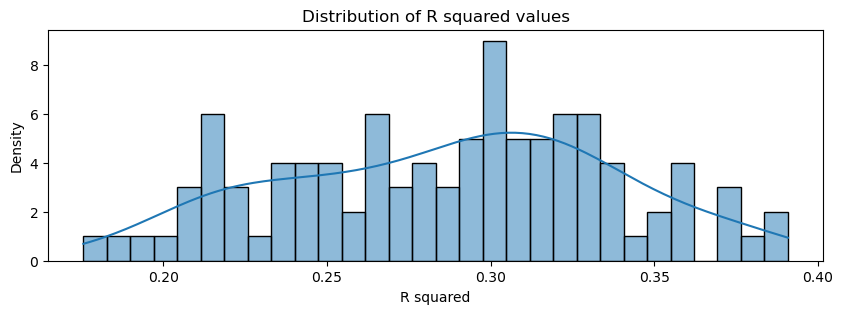

In [7]:
summarize_results(y_valid, y_pred_mean, rsquared_ensemble)

In [8]:
interactive_plot_predictions(
    country_valid=preprocessor.country_valid,
    y_valid=y_valid,
    y_pred_mean=y_pred_mean,
    y_pred_median=y_pred_median,
    y_pred_best=y_pred_best,
    y_pred_std=y_pred_std,
    title_prefix="GDP Prediction: "
)

interactive(children=(Dropdown(description='selected_country', options=('Canada', 'Germany', 'Japan', 'Korea',…

In [9]:
# THIS IS BASED ONLY ON THE FIRST MODEL !! NOT THE BOOTSTRAP MODELS
device = get_device(False)

# Get the predictions
x_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [10]:
# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})


In [11]:
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

In [ ]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

In [ ]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[(predictions_melted["country"] == selected_country) & (predictions_melted["Set"] == "Validation")]
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()


In [ ]:
def inverse_column_to_column_diff(data, col_name, grouping_by, mode, diff_period=1, sort_by=None):
    """
    Inverse of the _column_to_column_diff function.
    Reconstructs the original column values from the computed differences or percentage changes.

    Parameters
    ----------
    data : pd.DataFrame
        The data after applying _column_to_column_diff.
    col_name : str
        The name of the column that was modified by _column_to_column_diff.
    grouping_by : str
        The column to group by.
    mode : str
        The mode used in _column_to_column_diff ('diff' or 'pct').
    diff_period : int
        The period used in _column_to_column_diff.
    sort_by : str
        The column to sort the data by.

    Returns
    -------
    pd.DataFrame
        The data with the original column values reconstructed.
    """
    if sort_by:
        data.sort_values(sort_by, inplace=True)

    # Check if initial values are available
    initial_col_name = '_initial_' + col_name
    if initial_col_name not in data.columns:
        raise ValueError(f"Initial values are required and should be stored in '{initial_col_name}'.")

    if mode == 'diff':
        # Function to invert the diff operation for each group
        def invert_diff(group):
            # Initialize the reconstructed column with NaNs
            reconstructed = pd.Series(index=group.index, dtype=group[col_name].dtype)
            # Fill in the initial values
            reconstructed.iloc[:diff_period] = group[initial_col_name].iloc[:diff_period]
            # Compute the cumulative sum to reconstruct the original values
            reconstructed.iloc[diff_period:] = (
                group[col_name].iloc[diff_period:].cumsum() + reconstructed.iloc[diff_period - 1]
            )
            return reconstructed

        # Apply the inversion to each group
        data[col_name] = data.groupby(grouping_by, group_keys=False).apply(invert_diff)

    elif mode == 'pct':
        # Function to invert the pct_change operation for each group
        def invert_pct(group):
            # Initialize the reconstructed column with NaNs
            reconstructed = pd.Series(index=group.index, dtype=group[col_name].dtype)
            # Fill in the initial values
            reconstructed.iloc[:diff_period] = group[initial_col_name].iloc[:diff_period]
            # Compute the cumulative product to reconstruct the original values
            reconstructed.iloc[diff_period:] = (
                (group[col_name].iloc[diff_period:] + 1).cumprod() * reconstructed.iloc[diff_period - 1]
            )
            return reconstructed

        # Apply the inversion to each group
        data[col_name] = data.groupby(grouping_by, group_keys=False).apply(invert_pct)
    else:
        raise ValueError("Mode must be either 'diff' or 'pct'.")

    # Drop the initial values column as it's no longer needed
    data.drop(columns=[initial_col_name], inplace=True)

    return data


In [ ]:
predictions['date'] = pd.to_datetime(predictions['date'])
all_gdps['date'] = pd.to_datetime(all_gdps['date'])

predictions['y_pred'] = predictions['y_pred'] * (preprocessor.y_std - EPS) + preprocessor.y_mean
predictions['y_true'] = predictions['y_true'] * (preprocessor.y_std - EPS) + preprocessor.y_mean

all_gdps_merged_pred = predictions.merge(all_gdps, on=['country', 'date'], how='left')
all_gdps_merged_pred.head(10)

In [ ]:
# Ensure data is sorted
all_gdps_merged_pred.sort_values(['country', 'date'], inplace=True)

def reconstruct_gdp_pct(group):
    group = group.sort_values('date').reset_index(drop=True)
    predicted_gdp = []
    for i in range(len(group)):
        if i < 4:
            predicted_gdp.append(group.loc[i, 'GDP'])
        else:
            # Predicted GDP = Previous Predicted GDP * (1 + Predicted Percentage Change)
            pred_gdp = group.loc[i -4, 'GDP'] * (1 + group.loc[i, 'y_true'])
            predicted_gdp.append(pred_gdp)
    group['predicted_GDP'] = predicted_gdp
    return group

# Apply the reconstruction function
all_gdps_merged_pred_reconstructed = all_gdps_merged_pred.groupby('country', group_keys=False).apply(reconstruct_gdp_pct)

# View the result
print(all_gdps_merged_pred_reconstructed[['date', 'country', 'GDP', 'y_pred', 'predicted_GDP']])


In [ ]:
# Plot the results for a specific country
def plot_reconstructed_gdp(selected_country):
    # Filter the data for the selected country
    country_data = all_gdps_merged_pred_reconstructed[all_gdps_merged_pred_reconstructed['country'] == selected_country]
    
    # Plot the actual and predicted GDP
    plt.figure(figsize=(12, 6))
    plt.plot(country_data['date'], country_data['GDP'], label='Actual GDP')
    plt.plot(country_data['date'], country_data['predicted_GDP'], label='Predicted GDP')
    plt.title(f'Actual vs Predicted GDP for {selected_country}')
    plt.xlabel('Date')
    plt.ylabel('GDP')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = all_gdps_merged_pred_reconstructed['country'].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_reconstructed_gdp, selected_country=dropdown)


In [ ]:
all_gdps_merged_pred_reconstructed.head(5)